# 0.0 Imports

In [1]:
import os
import math
import json
import random
import pickle
import datetime
import inflection
import warnings
import requests

import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

from joblib                import dump
from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from scipy                 import stats    as ss
from matplotlib            import pyplot   as plt
from matplotlib            import gridspec as gs
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
# Ignoring warnings - be careful with this
warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [3]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def cross_validation(x_training, kfold, model_name, model,verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end validation dates 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # saving the performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name, 
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 0.2 Loading Data

In [4]:
path_sales = "C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/dataset/train.csv"
path_store = "C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/dataset/store.csv"
df_sales_raw = pd.read_csv(path_sales, low_memory=False)
df_store_raw = pd.read_csv(path_store, low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [9]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Checking NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [14]:
# competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo 2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude=['int32', 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

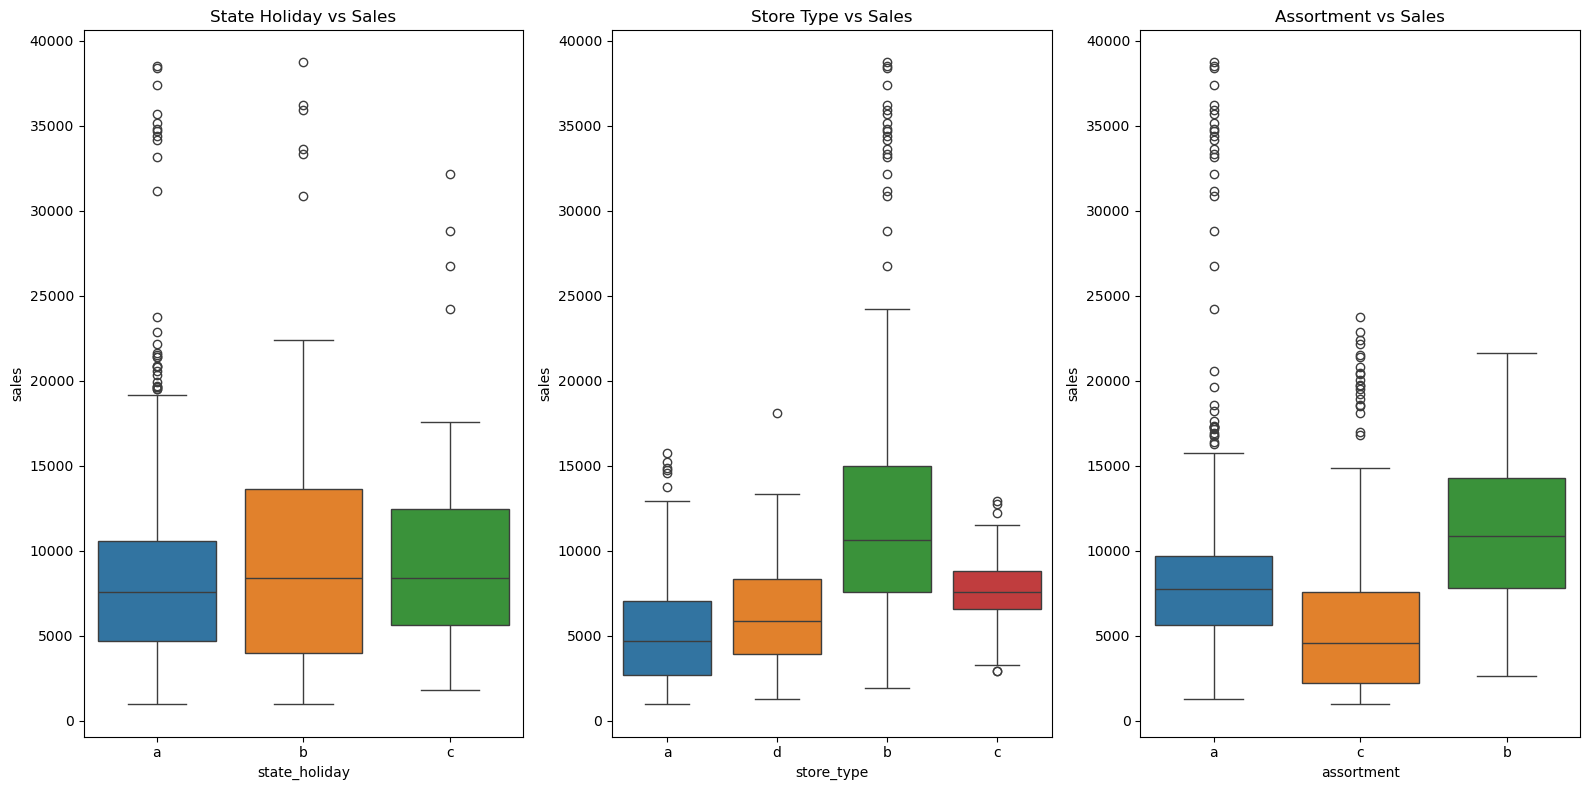

In [19]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday')
plt.title('State Holiday vs Sales')

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1, hue='store_type')
plt.title('Store Type vs Sales')

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1, hue='assortment')
plt.title('Assortment vs Sales')

plt.tight_layout()

plt.show()

# 2.0 Feature Engineering

In [20]:
df2 = df1.copy()

## 2.1 Hypotheses Mindmap

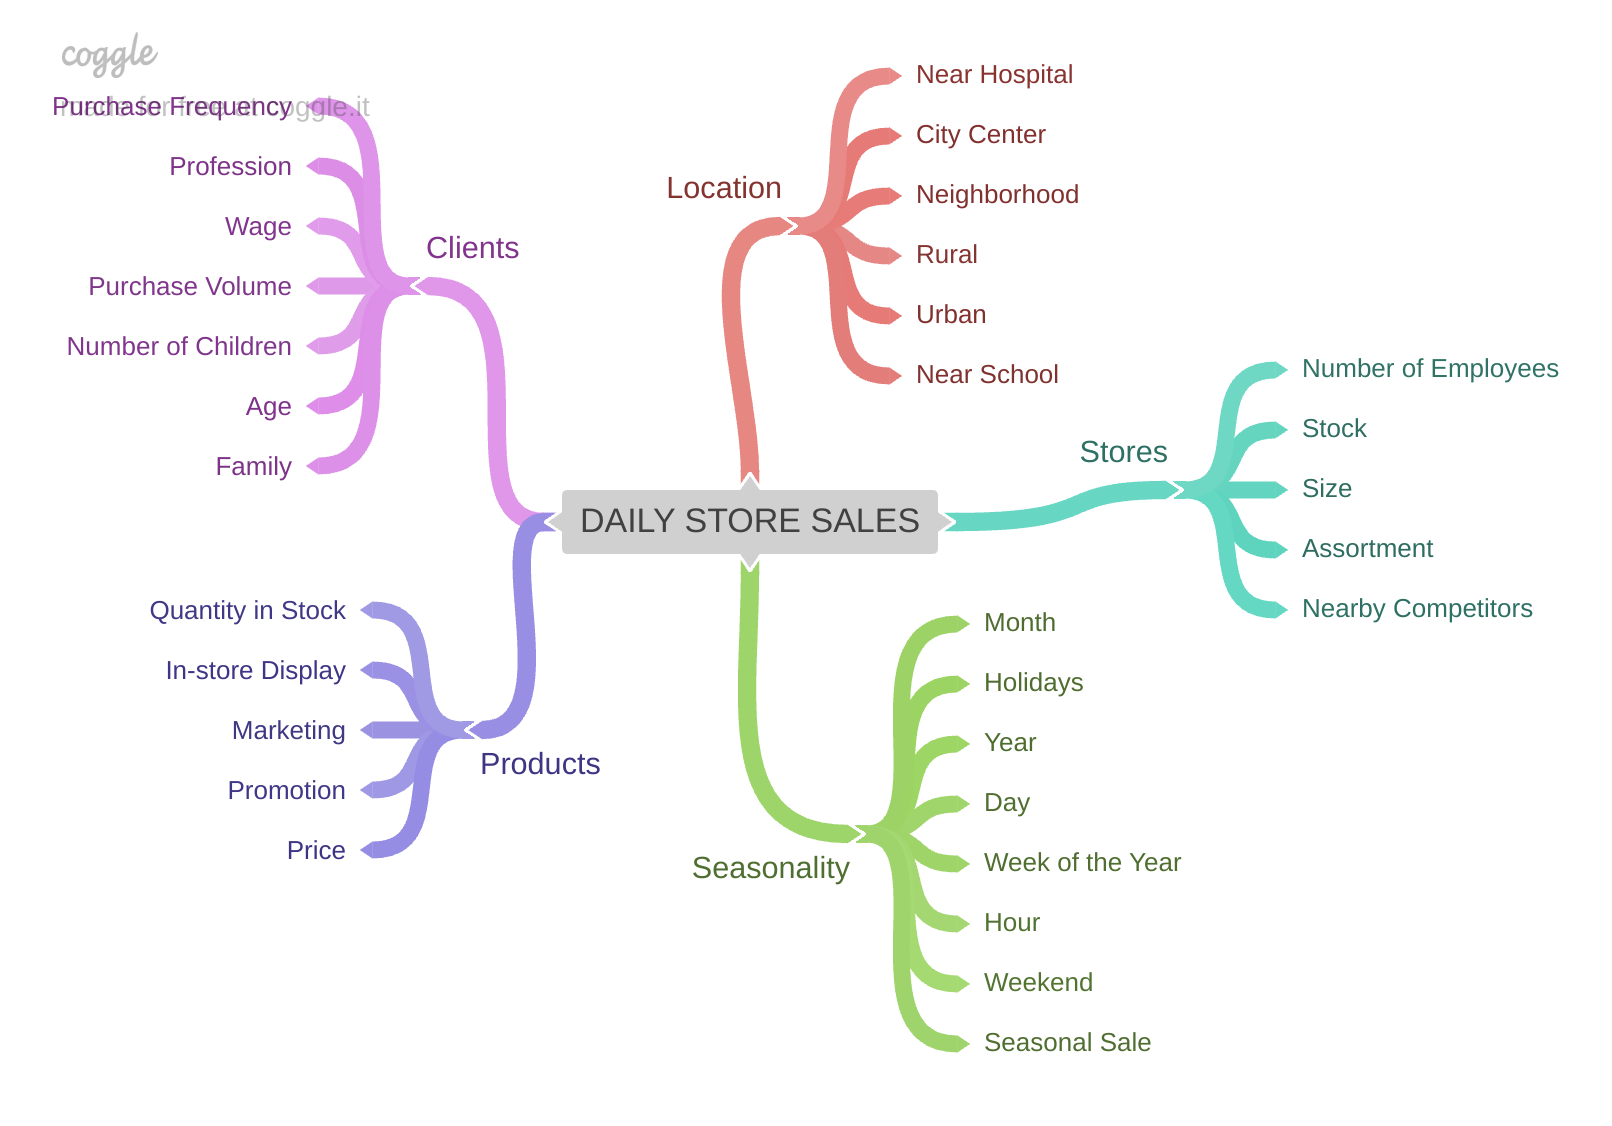

In [21]:
Image('img/mindmapHypothesis.png')

## 2.2 Creation of Hypotheses

### 2.2.1 Stores Hypotheses

**1.** Stores with larger staff should sell more.

**2.** Stores with greater stock capacity should sell more. 

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less. 

**6.** Stores with competitors for longer should sell more.

### 2.2.2 Products Hypotheses

**1.** Stores that invest more in marketing should sell more. 

**2.** Stores that display the product more should sell more. 

**3.** Stores that have lower prices on products should sell more.

**4.** Stores that have lower prices for longer should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more. 

**6.** Stores with active promotions for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3 Seasonal Hypotheses

**1.** Stores which open during Christmas holiday should sell more. 

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3 Final List of Hypotheses

**Stores Hypotheses**

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less. 

**3.** Stores with competitors for longer should sell more.

**Products Hypotheses**

**4.** Stores with active promotions for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**Seasonal Hypotheses**

**7.** Stores which open during Christmas holiday should sell more. 

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4 Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Variable Filtering

In [23]:
df3 = df2.copy()

## 3.1 Rows Filtering

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Exploratory Data Analysis

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<Axes: xlabel='sales', ylabel='Count'>

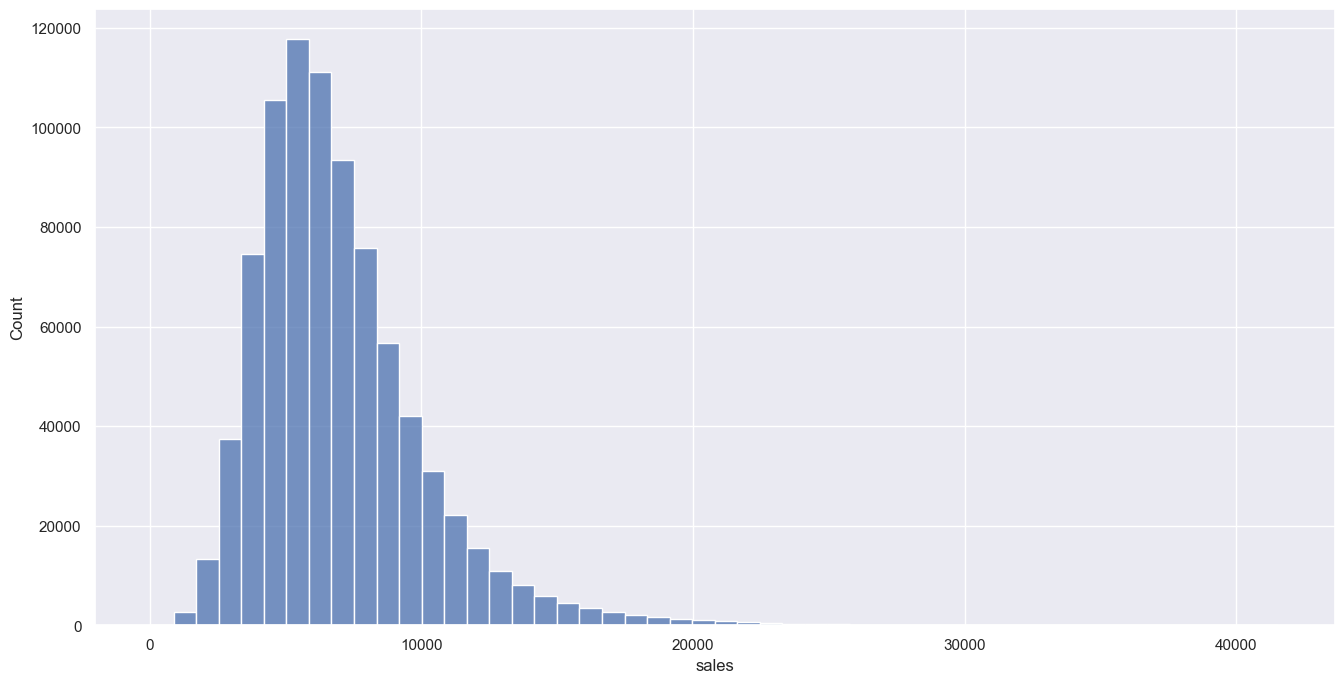

In [27]:
sns.set_theme(rc={'figure.figsize':(16, 8)})
sns.histplot(df4['sales'], stat='count', bins=50)

### 4.1.2 Numerical Variables

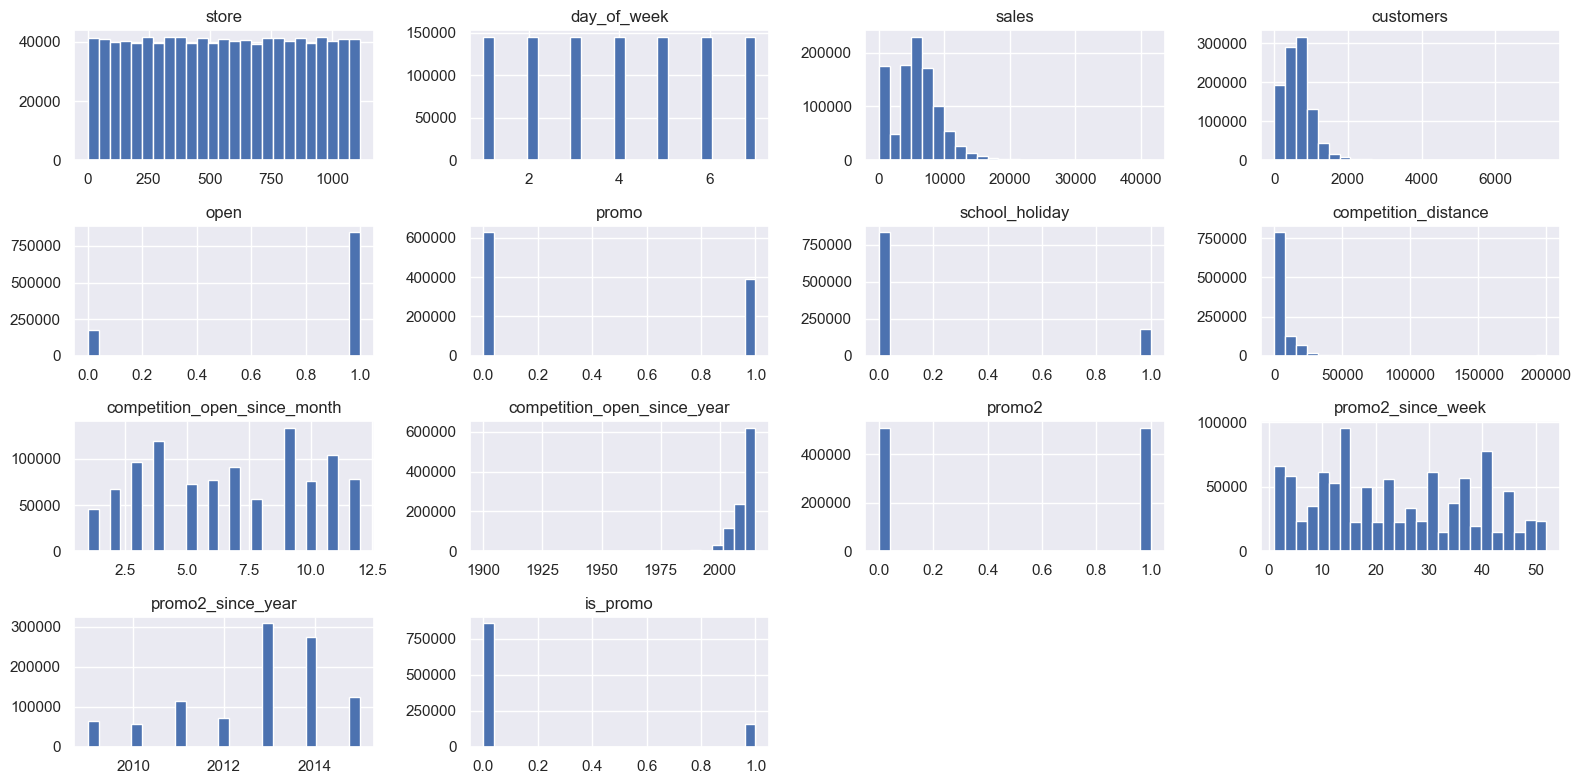

In [28]:
num_attributes.hist(bins=25);
plt.tight_layout()
plt.show()

### 4.1.3 Categorical Variables

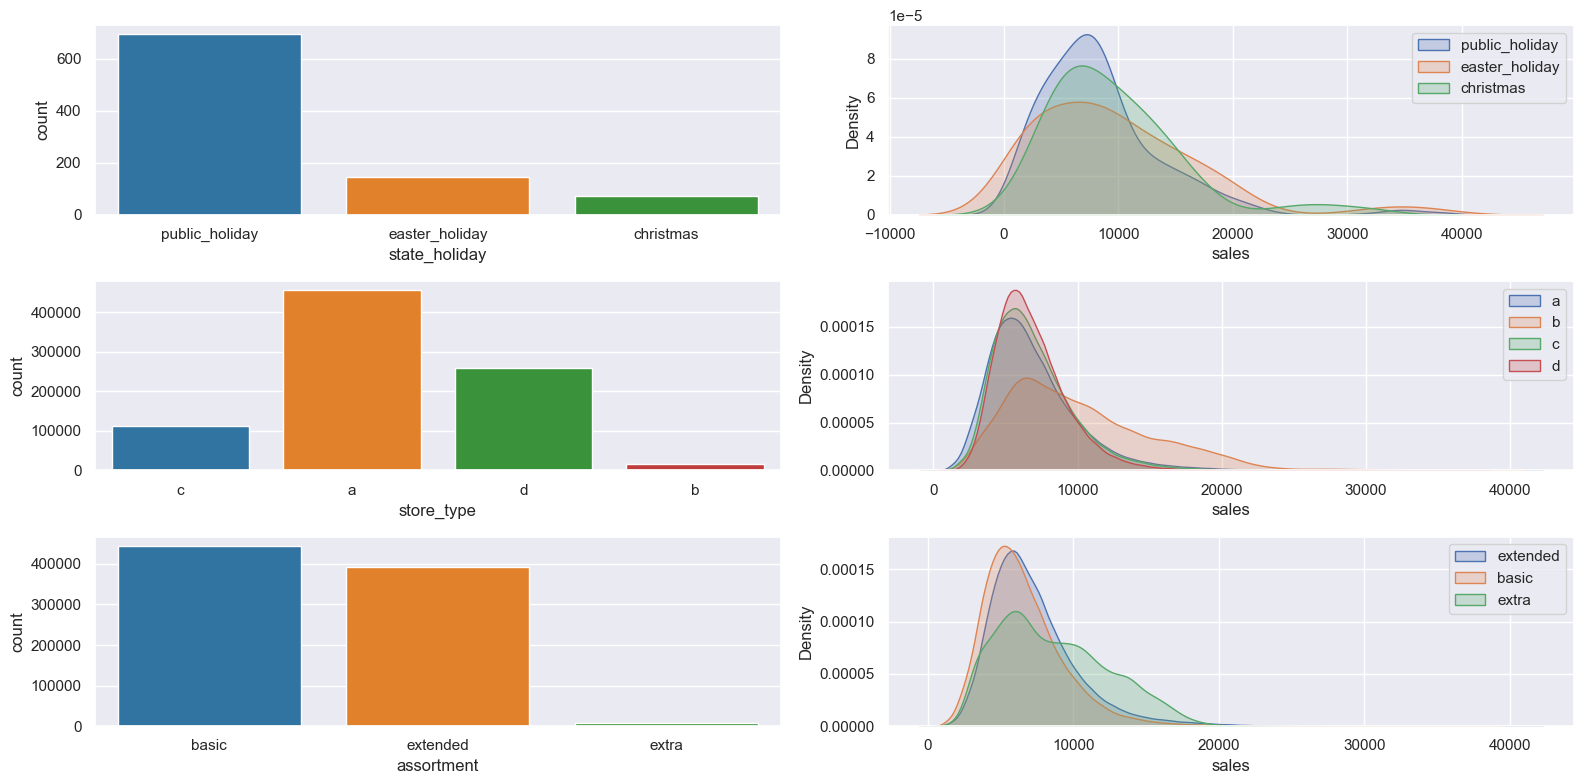

In [29]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday', hue='state_holiday', palette='tab10')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()
plt.tight_layout()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(data=df4, x='store_type', hue='store_type', palette='tab10')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()
plt.tight_layout()

#assortment
plt.subplot(3, 2, 5)
sns.countplot(data=df4, x='assortment', hue='assortment', palette='tab10')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend()
plt.tight_layout()

## 4.2 Bivariate Analysis

### H1. Stores with a larger assortment should sell more.
**FALSE** - Stores with larger assortment sell less.

<Axes: xlabel='year_week'>

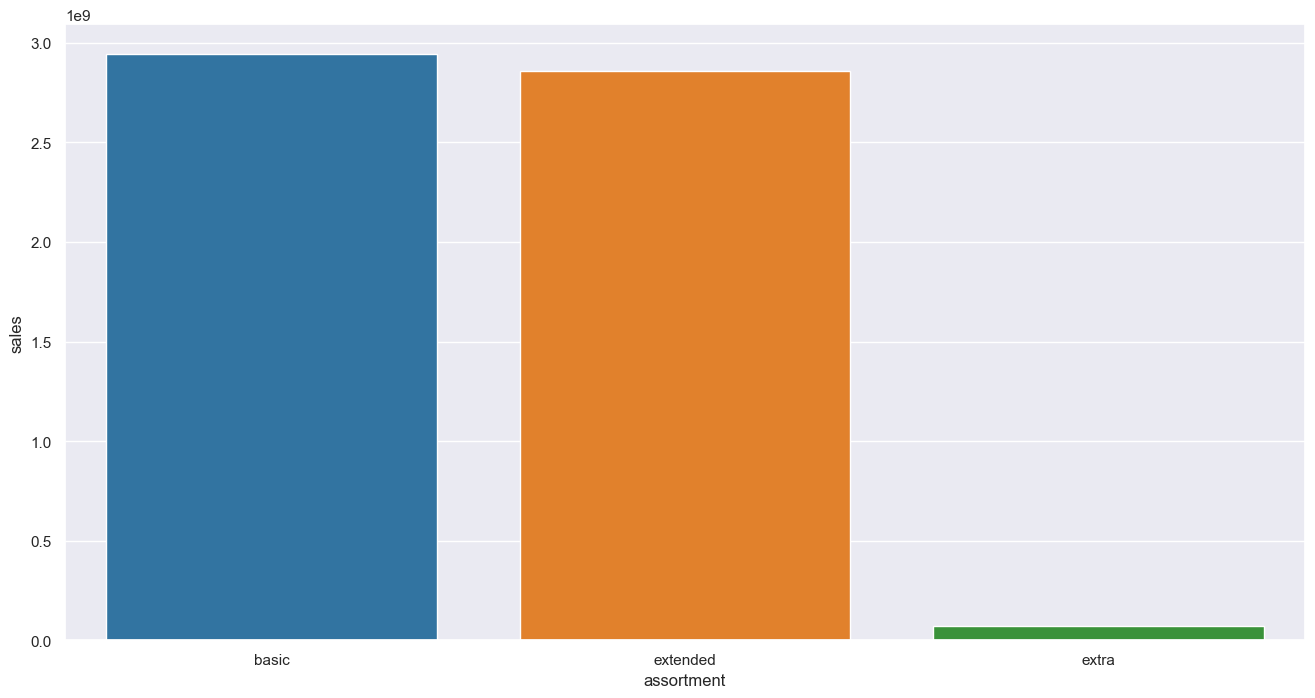

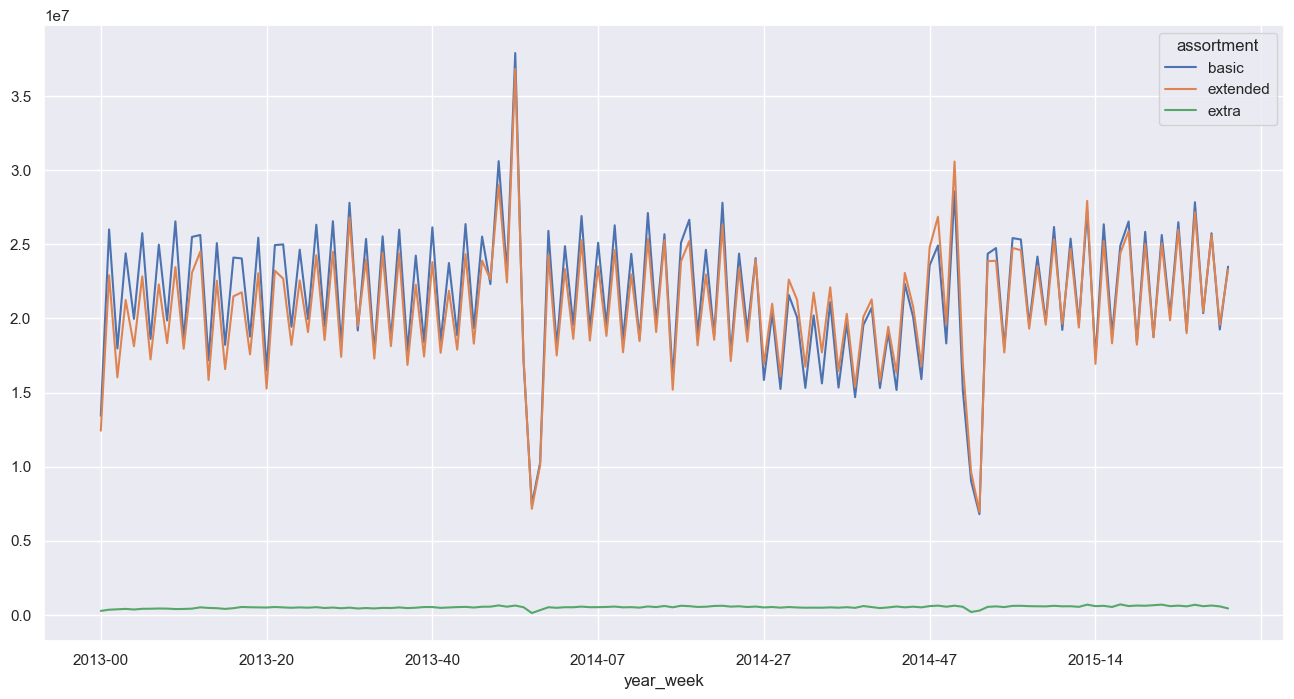

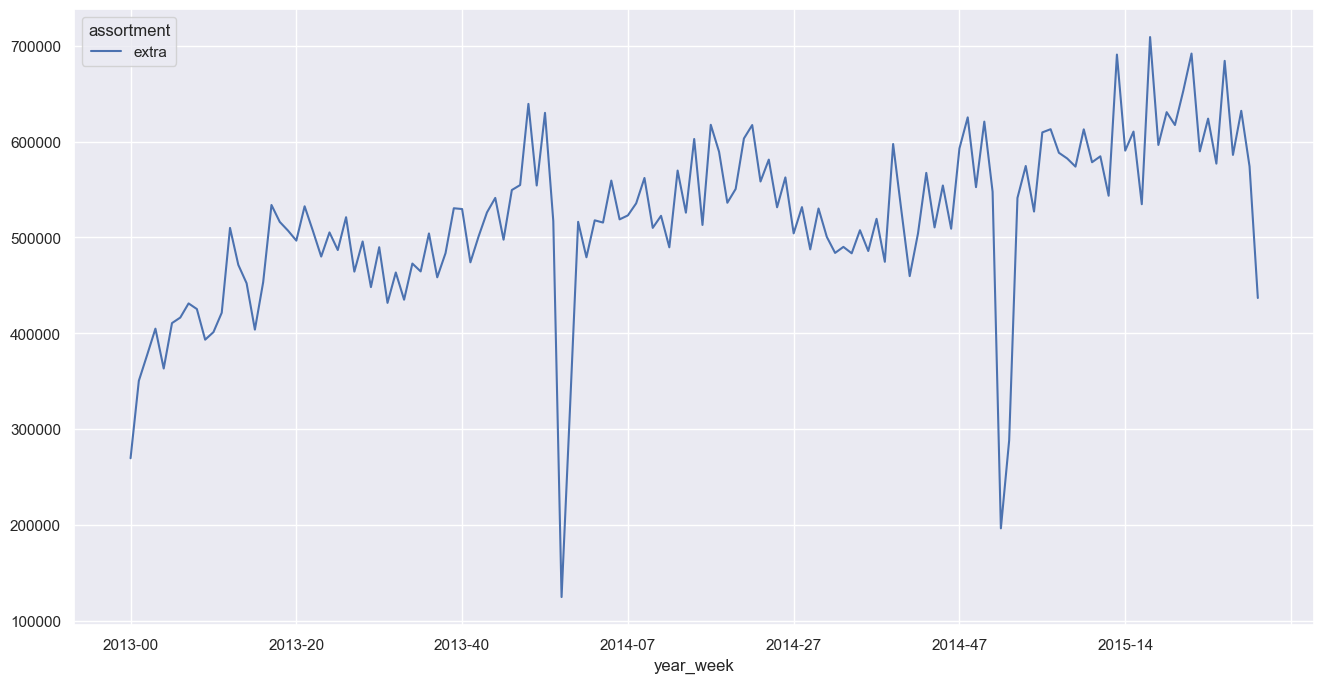

In [30]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, hue='assortment', legend=False, palette='tab10');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Stores with closer competitors should sell less.
**FALSE** - Stores with closer competitors sell more.

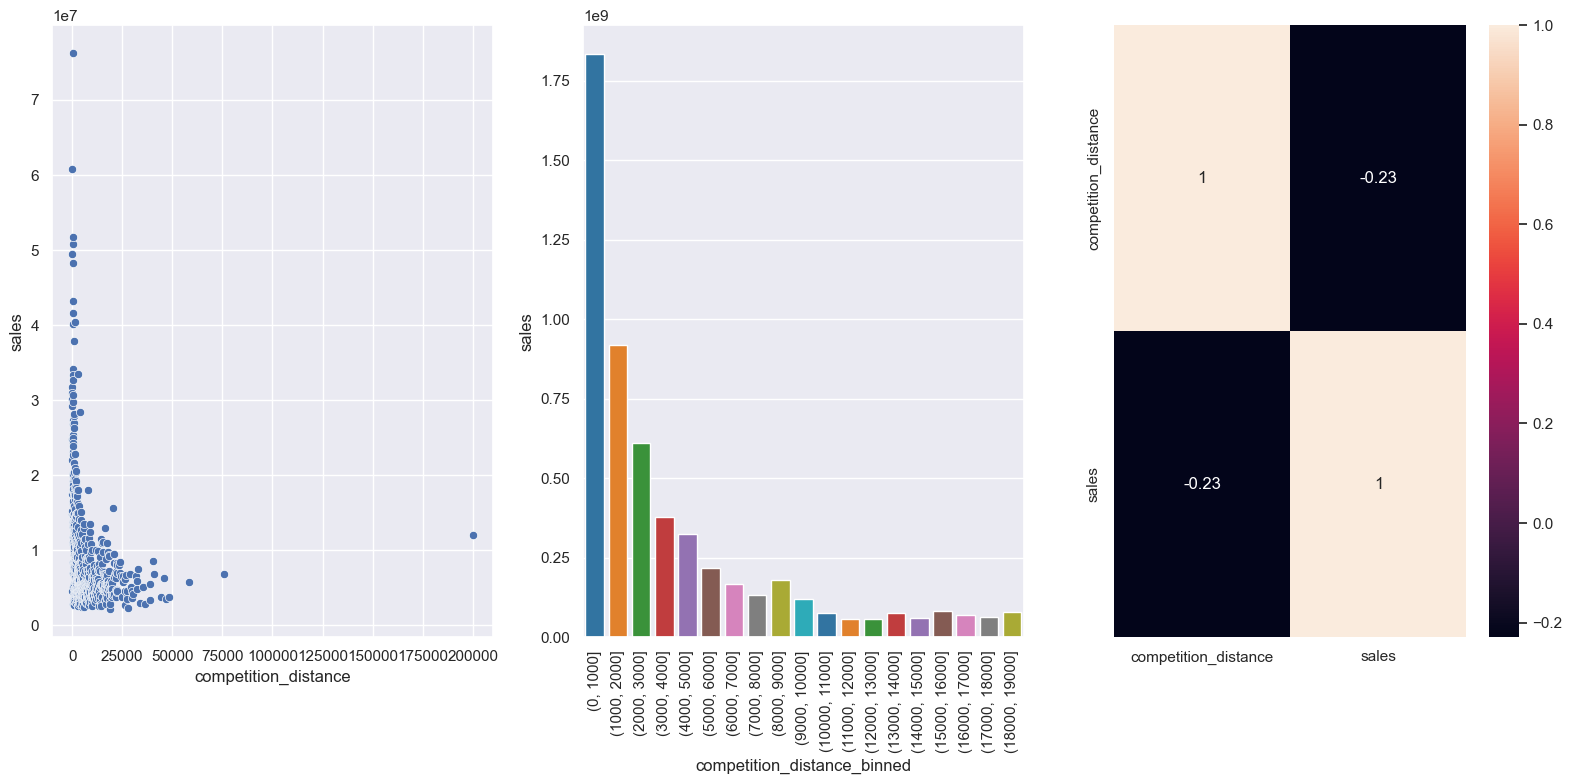

In [31]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned', observed=False).sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned', legend=False, palette='tab10')
plt.xticks(rotation=90);

aux1_corr = aux1.select_dtypes(include='number')
plt.subplot(1, 3, 3)
x = sns.heatmap(aux1_corr.corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show()

### H3. Stores with competitors for longer should sell more.
**FALSE** - Stores with competitors for longer sell less.

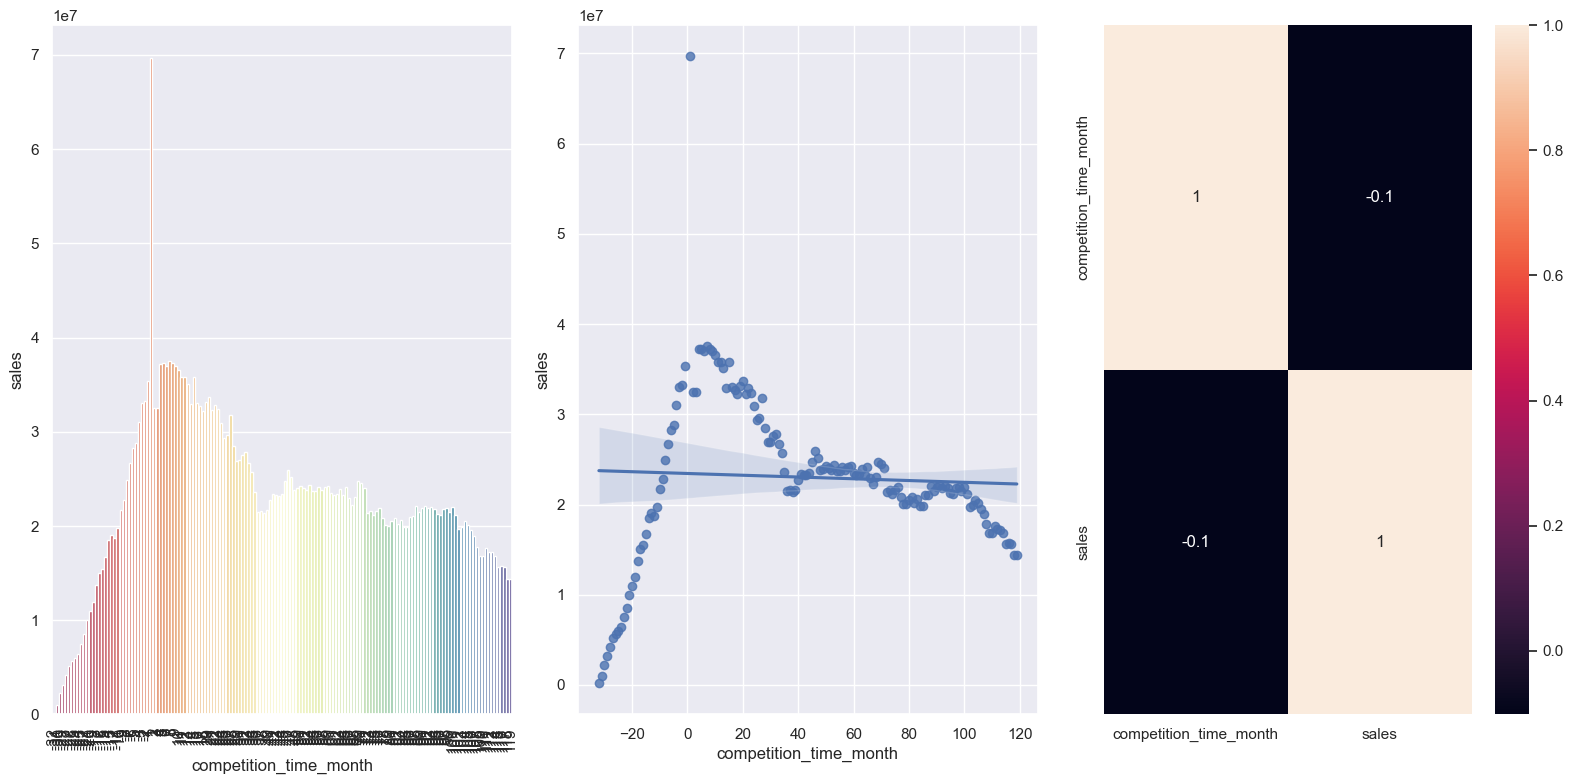

In [32]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2, hue='competition_time_month', legend=False, palette='Spectral');
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
aux1_corr = aux1.select_dtypes(include='number')
sns.heatmap(aux1_corr.corr(method='pearson'), annot=True);

plt.tight_layout()
plt.show()

### H4. Stores with active promotions for longer should sell more.
**FALSE** - Stores with active promotions for longer sell less, after a certain period.

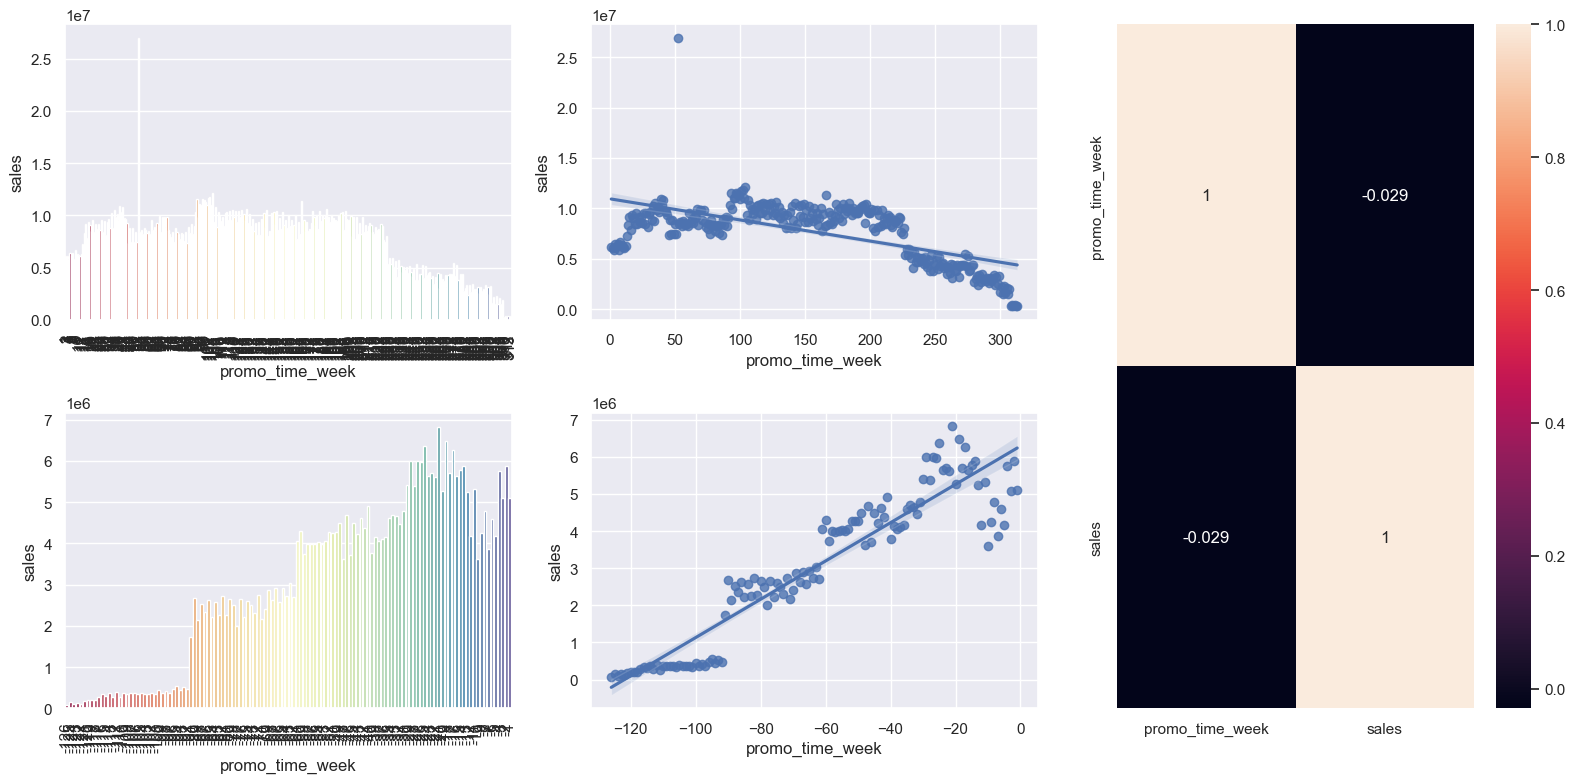

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gs.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo
sns.barplot(x='promo_time_week', y='sales', data=aux2, hue='promo_time_week', legend=False, palette='Spectral');
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3, hue='promo_time_week', legend=False, palette='Spectral');
plt.xticks(rotation=90);

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True) 

plt.tight_layout()
plt.show()

### <s>H5. Stores with more promotion days should sell more.</s>



### H6. Stores with more consecutive promotions should sell more.
**FALSE** - Stores with more consecutive promotions sell less.

In [34]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


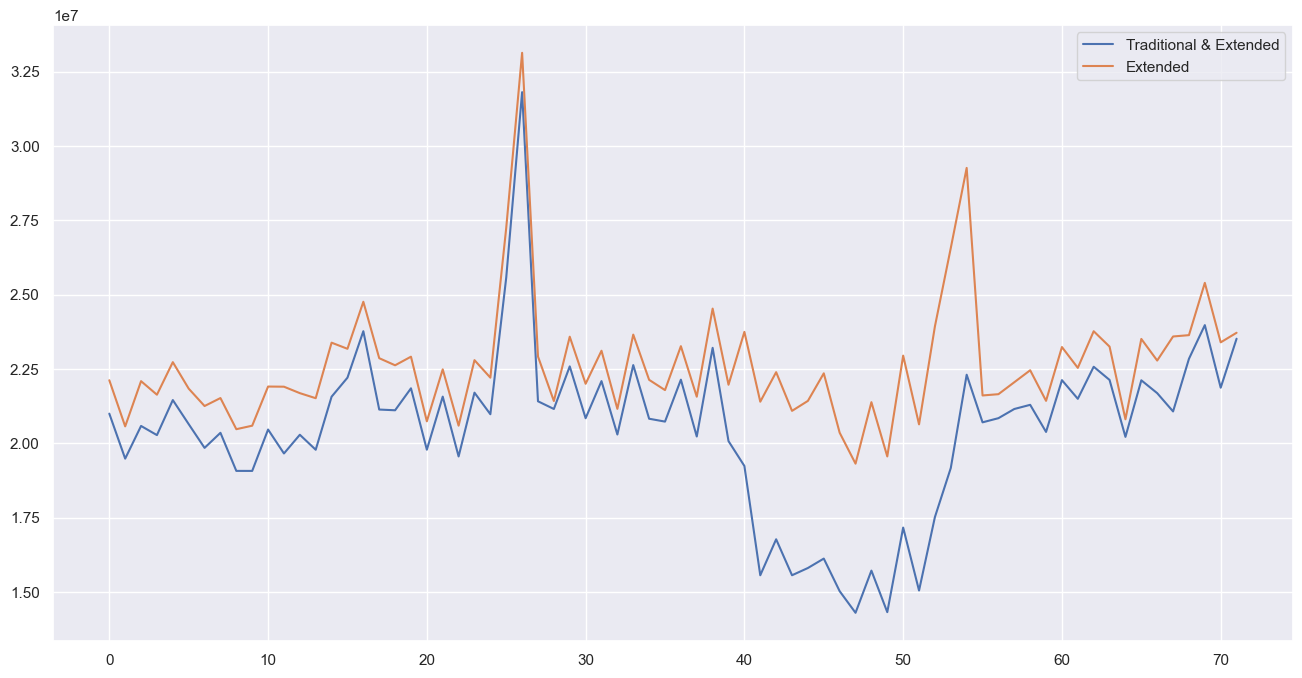

In [35]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extended', 'Extended']);

### H7. Stores which open during Christmas holiday should sell more.
**FALSE** - Stores which opened during Christmas holiday sold less.

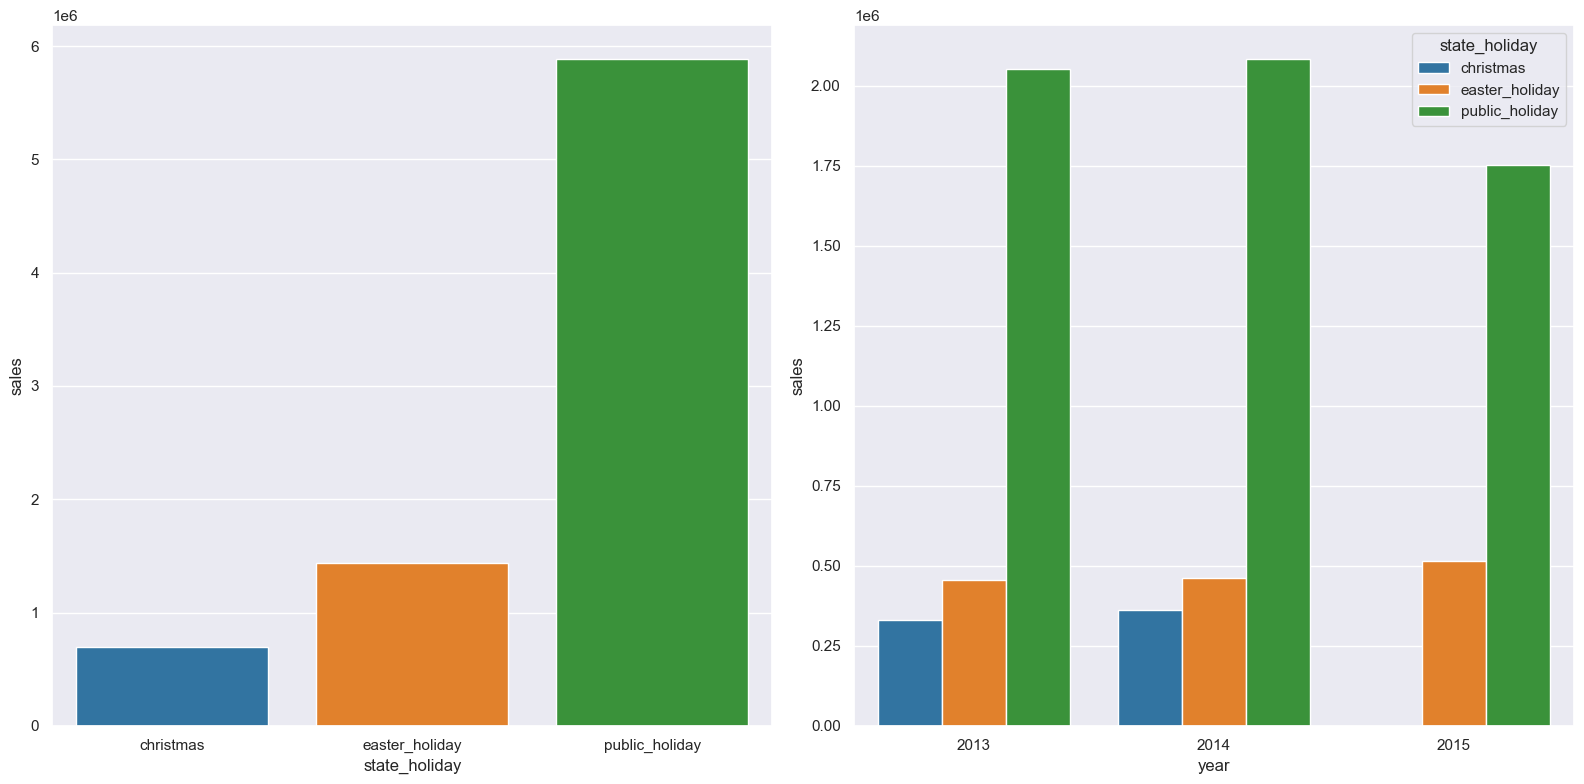

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday', legend=False, palette='tab10');

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2, hue='state_holiday', legend=True, palette='tab10');

plt.tight_layout()

### H8. Stores should sell more over the years.
**FALSE** - Stores sell less over the years.

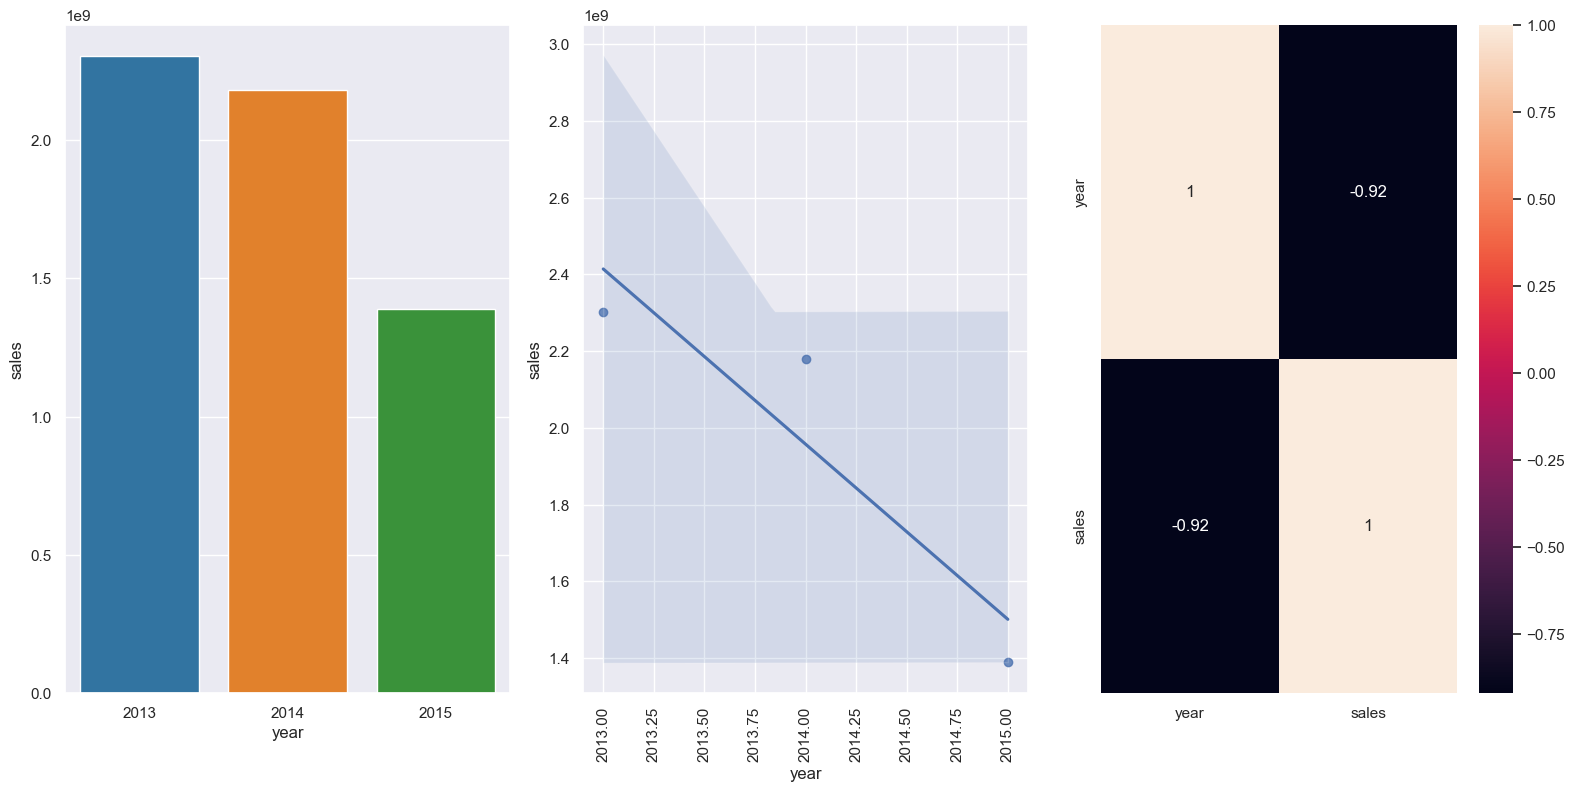

In [37]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1, hue='year', legend=False, palette='tab10');

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.tight_layout()

### H9. Stores should sell more in the second half of the year.
**FALSE** - Stores sell less in the second half of the year.

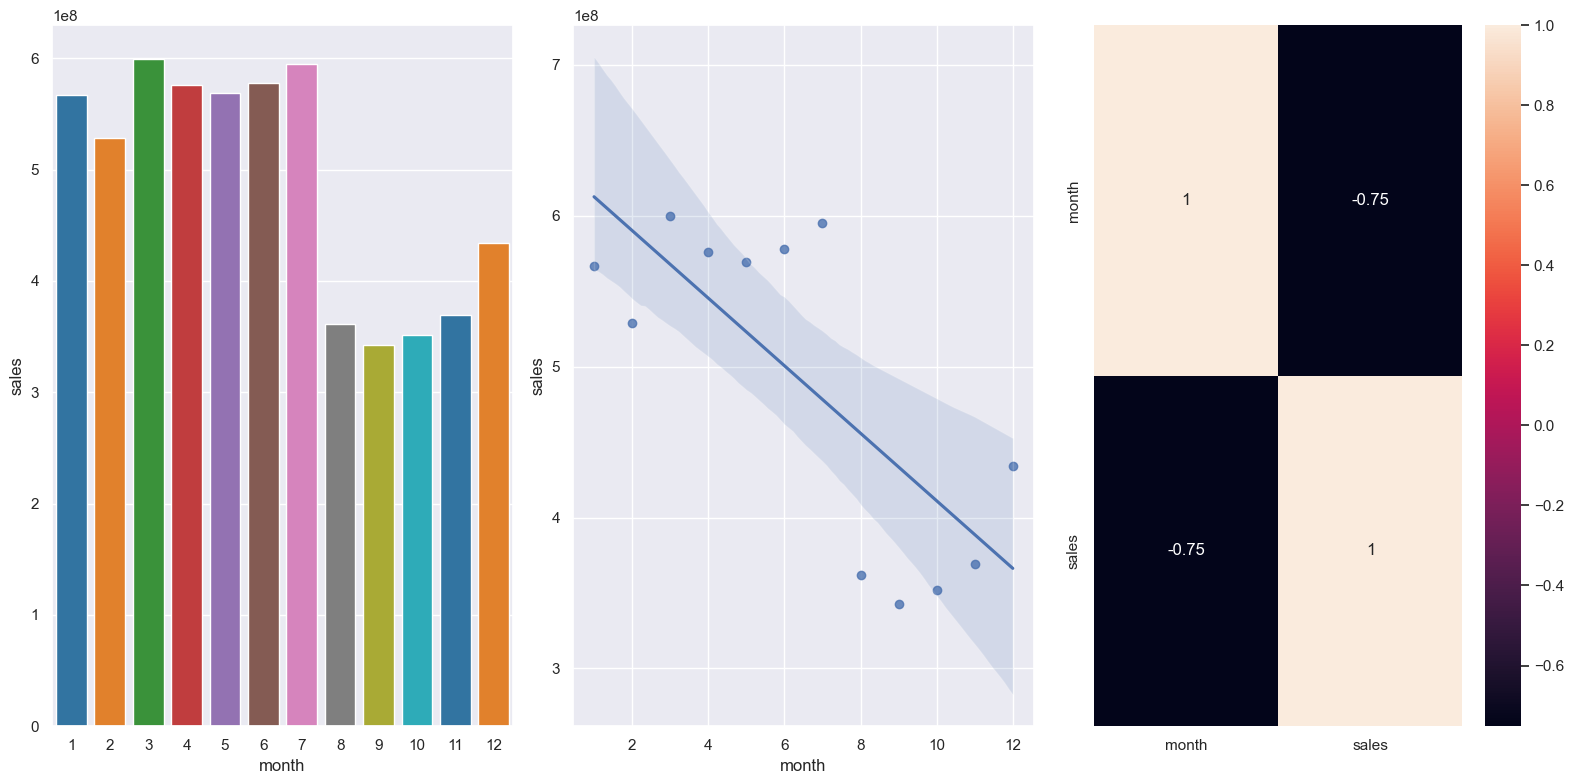

In [38]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1, hue='month', legend=False, palette='tab10');

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.tight_layout()

### H10. Stores should sell more after the 10th day of each month.
**TRUE** - Stores sell more after the 10th day of each month.

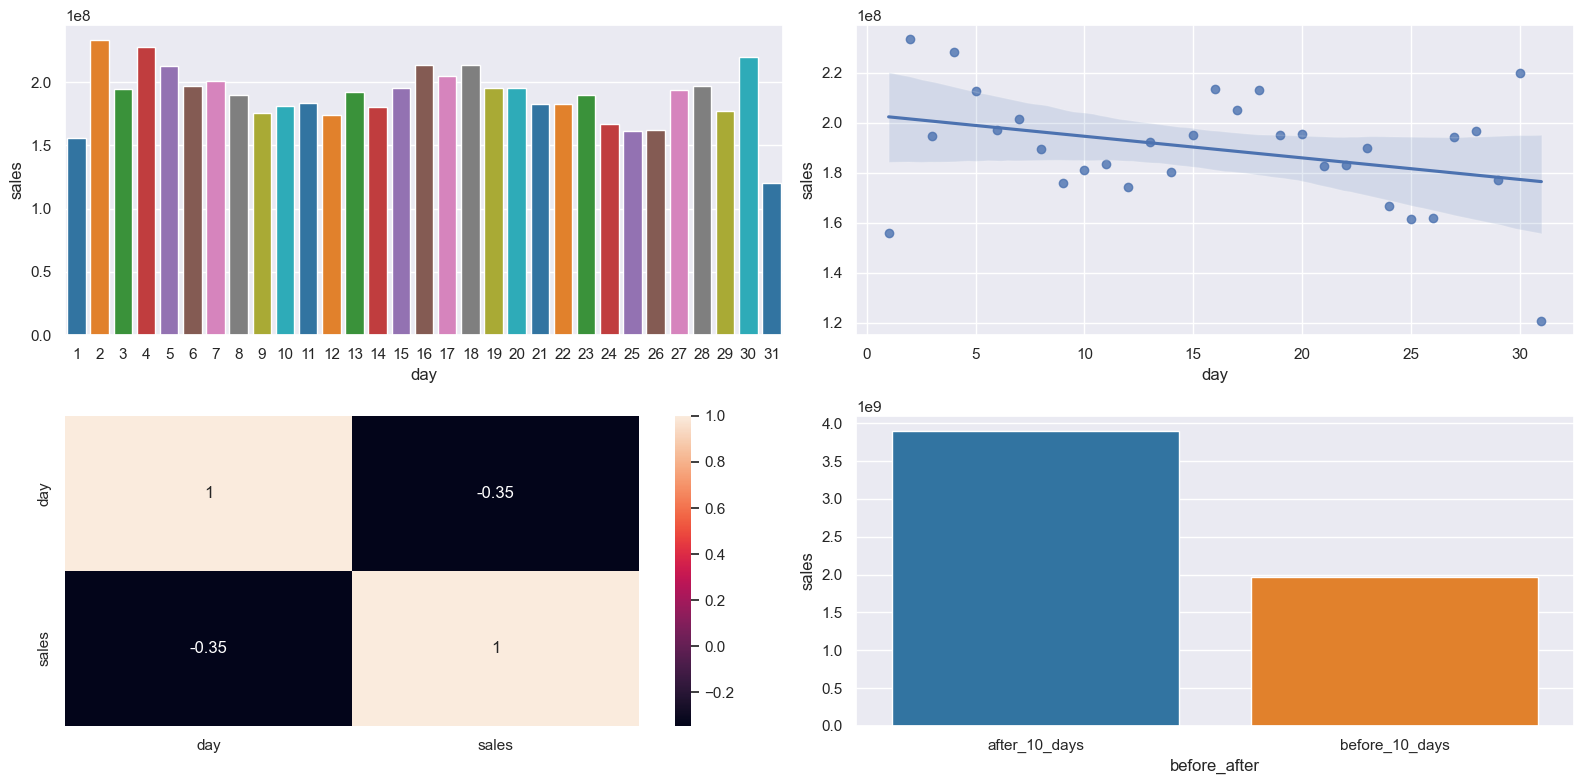

In [39]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1, hue='day', legend=False, palette='tab10');

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2, hue='before_after', legend=False, palette='tab10')

plt.tight_layout()

### H11. Stores should sell less on weekends.
**TRUE** - Stores sell less on weekends.

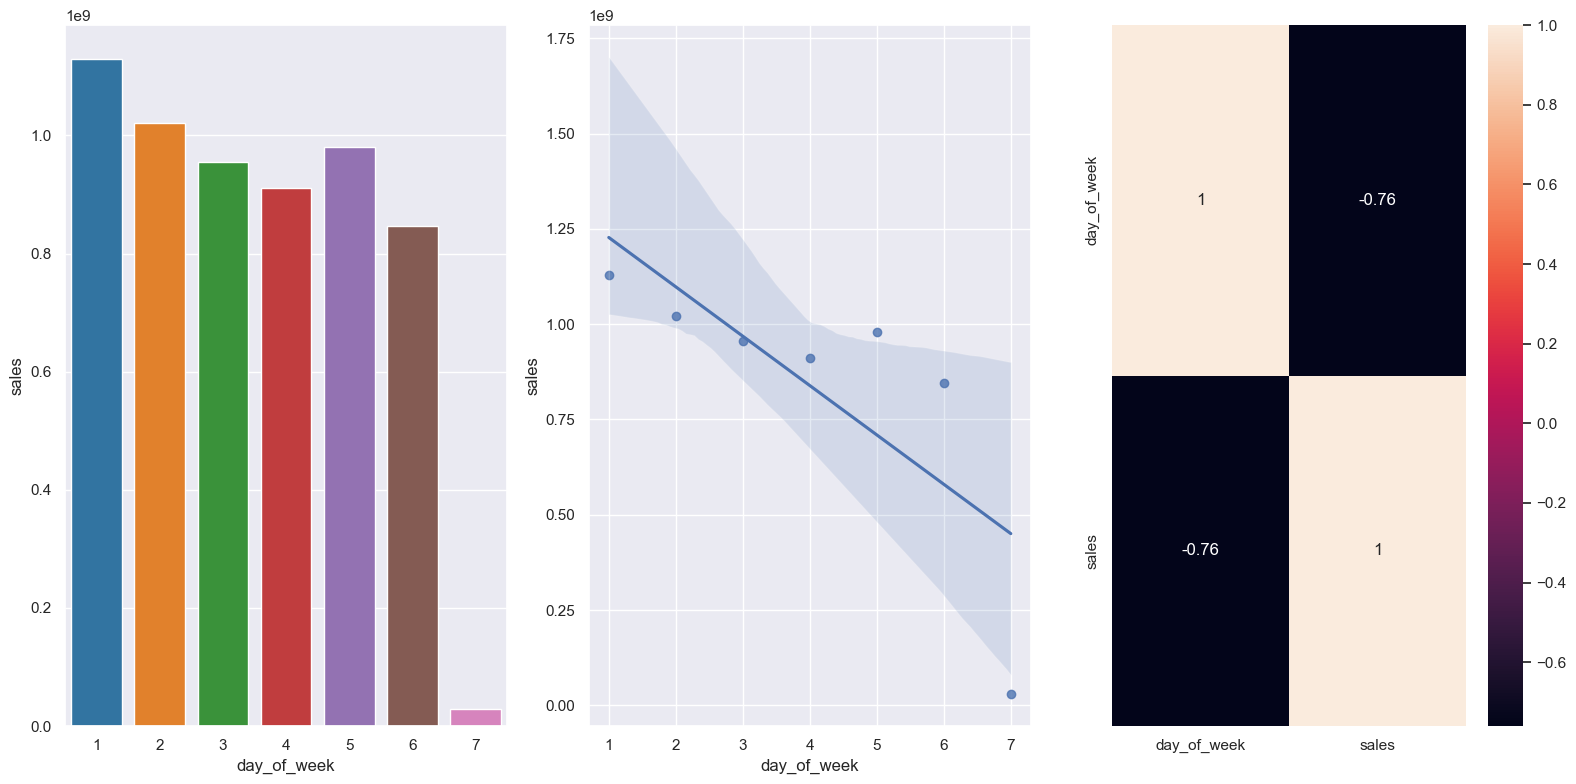

In [40]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1, hue='day_of_week', legend=False, palette='tab10');

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.tight_layout()

### H12. Stores should sell less during school holidays.
**TRUE** - Stores sell less during school holidays, except in July and August.

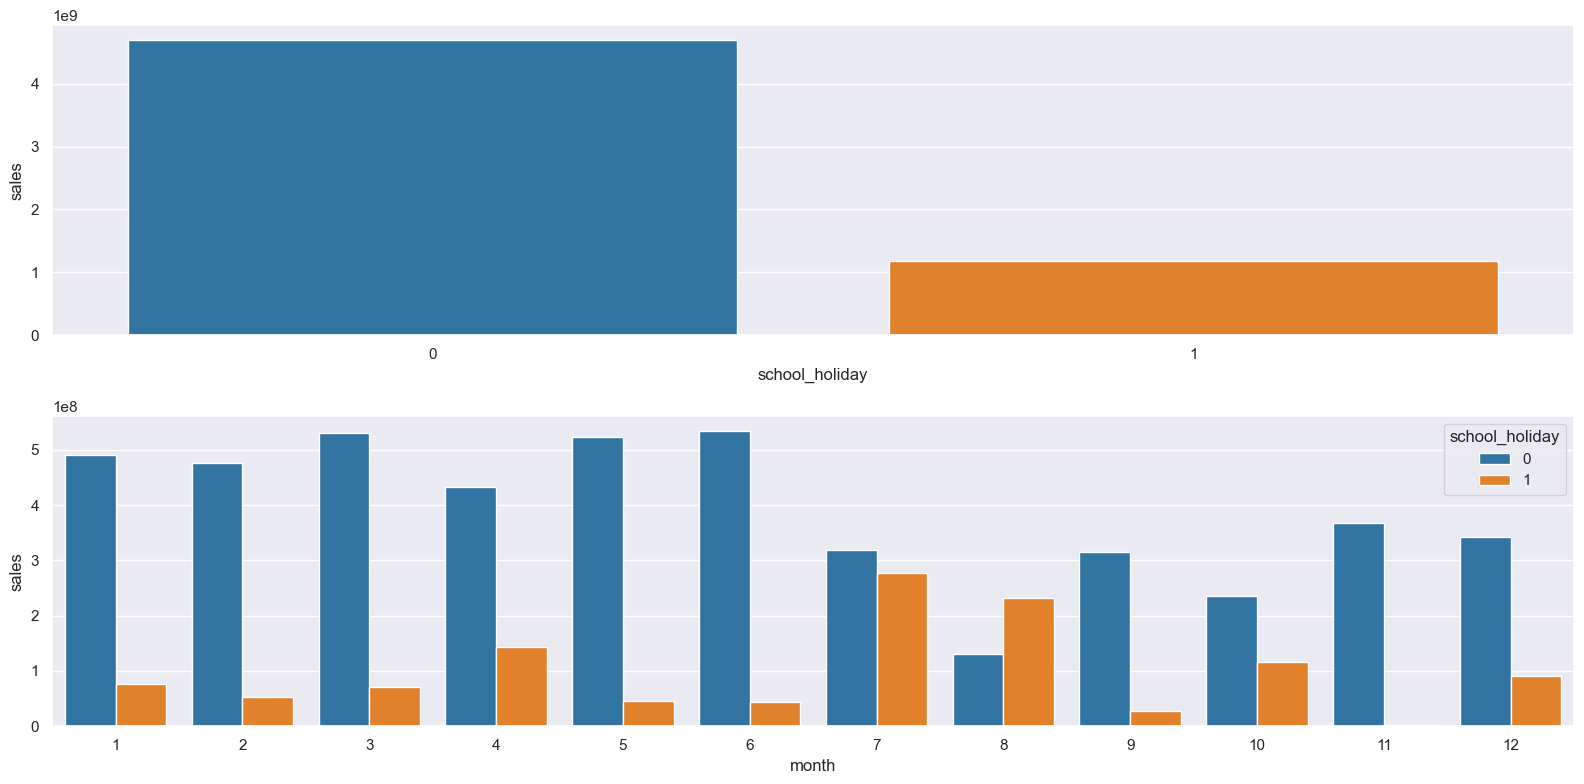

In [41]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1 ,1)
sns.barplot(x='school_holiday', y='sales', data=aux1, hue='school_holiday', legend=False, palette='tab10');

aux2 = df4[['month', 'school_holiday','sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2, 1 ,2)
sns.barplot(x='month', y='sales', data=aux2, hue='school_holiday', legend=True, palette='tab10');

plt.tight_layout()

### 4.2.1 Hypotheses Summary

In [42]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'False', 'Low'],
       ['H2', 'False', 'Medium'],
       ['H3', 'False', 'Medium'],
       ['H4', 'False', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'False', 'Low'],
       ['H7', 'False', 'Medium'],
       ['H8', 'False', 'High'],
       ['H9', 'False', 'High'],
       ['H10', 'True', 'High'],
       ['H11', 'True', 'High'],
       ['H12', 'True', 'Low']
       ]
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

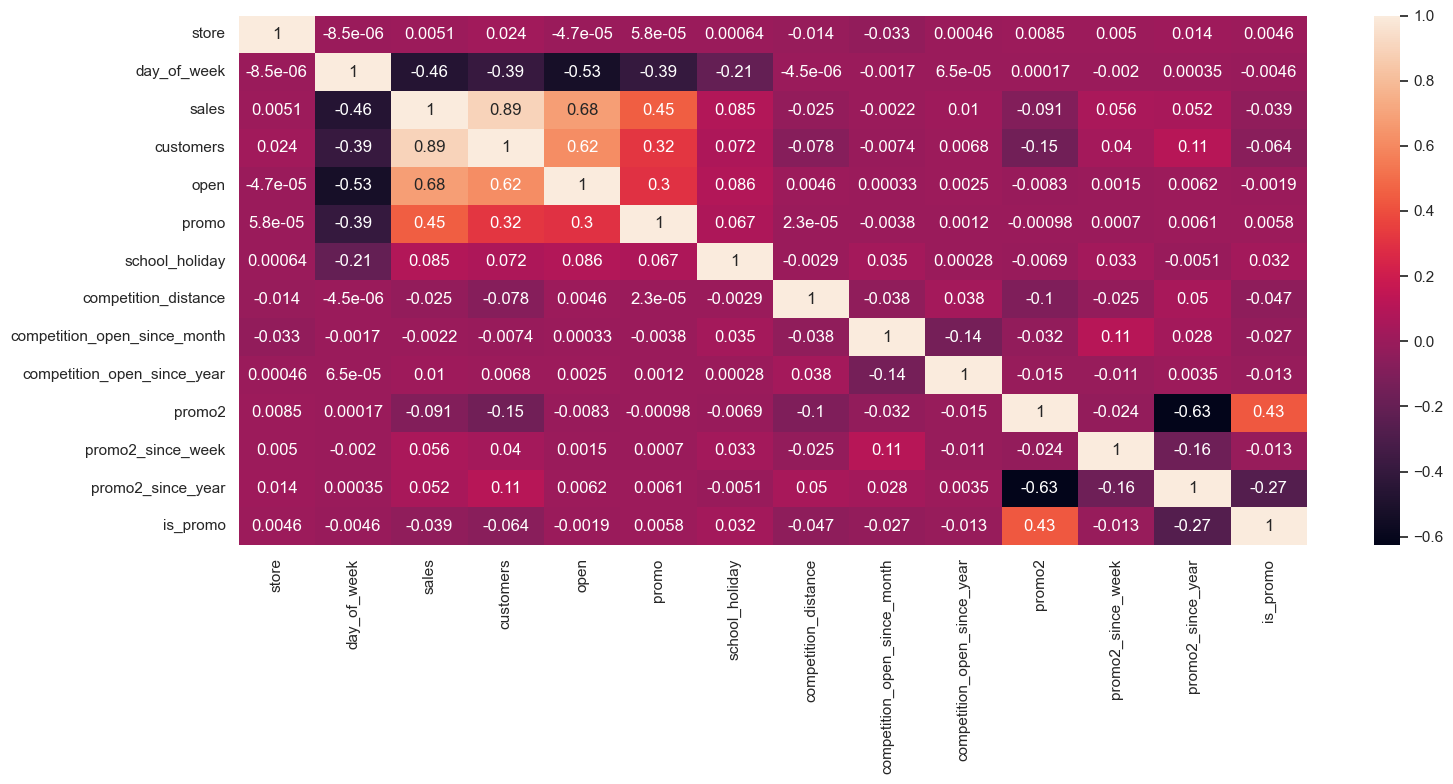

In [43]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);
plt.tight_layout()

### 4.3.2 Categorical Attributes

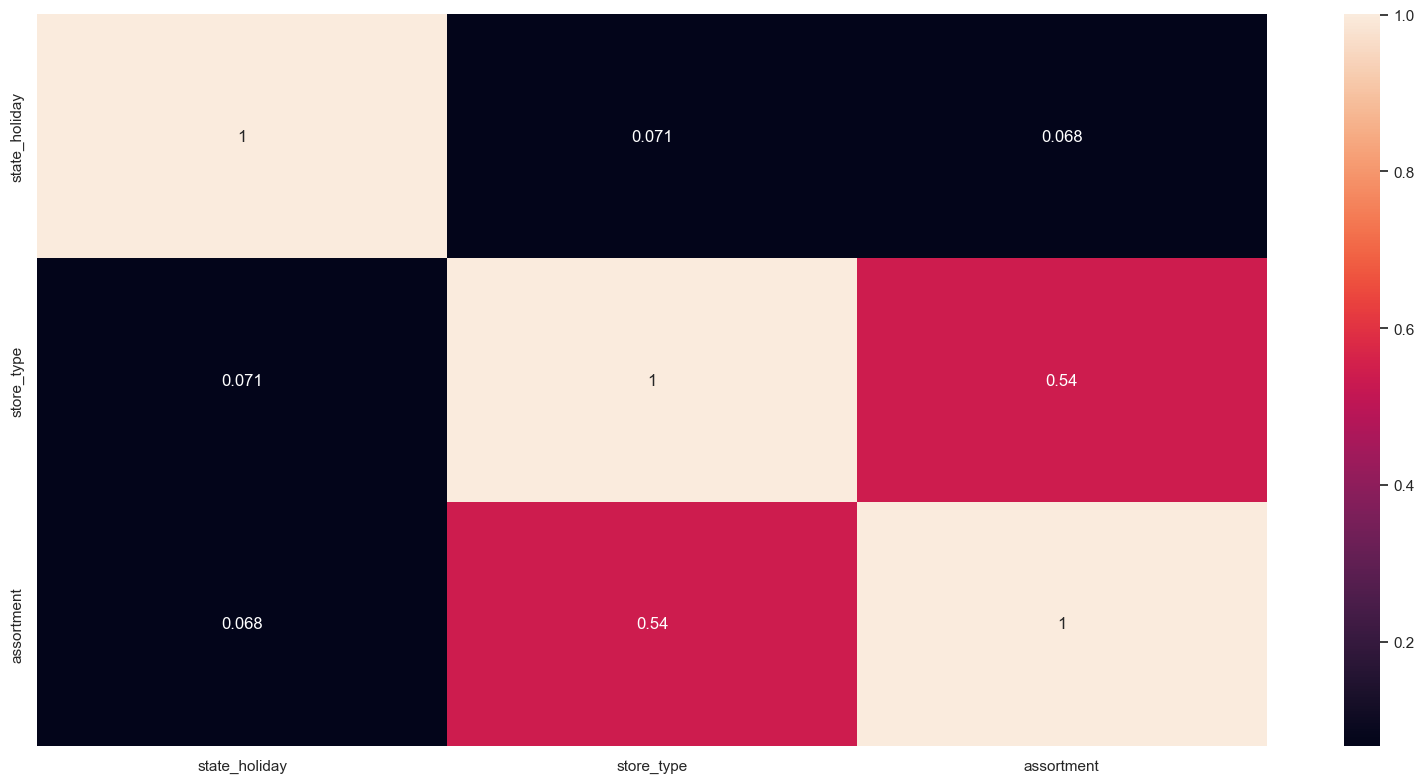

In [44]:
# only categorical data
a = df4.select_dtypes(include='object')

# calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)
plt.tight_layout()

# 5.0 Data Preparation

In [45]:
df5 = df4.copy()

## 5.1 Normalization

Searching in the section 4.1.2, there is no variables with a normal distribution. Therefore, it's preferable not to do any type of normalization.

## 5.2 Rescaling

In [46]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [47]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [48]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [49]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))

# 6.0 Feature Selection

In [50]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [51]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [52]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [53]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [54]:
######## WARNING ########

# This snippet took 3h30 to run. The results are saved in the section 6.3 as 'cols_selected_boruta'.

## training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor 
#rf = RandomForestRegressor(n_jobs=1)
#
## define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [55]:
######## WARNING ########

# This snippet only run after the snippet before (3h30). The results are saved in the section 6.3 as 'cols_selected_boruta'.

#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [56]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [57]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [58]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [59]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [60]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [61]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Lasso - Cross Validation

In [62]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [63]:
######## WARNING ########

# This snippet took 5 minutes to run. The results are saved in the table called 'tab_single_performance'.

# model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
#
## prediction
#yhat_rf = rf.predict(x_test)
#
## performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [64]:
######## WARNING ########

# This snippet took 21 minutes to run. The results are saved in the table called 'tab_real_performance'.

#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

## 7.5 XGBoost Regressor

In [65]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.3,
                             max_depth=6,
                             subsample=1,
                             colsample_bytree=1).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,860.433707,0.128868,1232.368137


### 7.5.1 XGBoost Regressor - Cross Validation

In [66]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1057.93 +/- 145.68,0.15 +/- 0.02,1513.43 +/- 206.0


## 7.6 Compare Models Performance

### 7.6.1 Single Performance

In [67]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

#### 7.6.1.1 Single Performance Results Table

In [68]:
# copy of results from the snippet 7.6.1 so it's not necessary to run all the ml models

tab_single_performance = [['Model Name',                'MAE',        'MAPE',     'RMSE'],
                          ['Random Forest Regressor',   '679.598831', '0.099913', '1011.119437'],
                          ['XGBoost Regressor',         '860.433707', '0.128868', '1232.368137'],
                          ['Average Model',             '1354.800353', '0.206400', '1835.135542'],
                          ['Linear Regression',         '1867.089774', '0.292694', '2671.049215'],
                          ['Linear Regression - Lasso', '1891.704881', '0.289106', '2744.451737']]

print(tabulate(tab_single_performance, headers='firstrow'))

Model Name                      MAE      MAPE     RMSE
-------------------------  --------  --------  -------
Random Forest Regressor     679.599  0.099913  1011.12
XGBoost Regressor           860.434  0.128868  1232.37
Average Model              1354.8    0.2064    1835.14
Linear Regression          1867.09   0.292694  2671.05
Linear Regression - Lasso  1891.7    0.289106  2744.45


### 7.6.2 Real Performance

In [69]:
#modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv.sort_values('RMSE CV')

#### 7.6.1.2 Real Performance Results Table

In [70]:
# copy of results from the snippet 7.6.2 so it's not necessary to run all the ml models

tab_real_performance = [['Model Name',                'MAE CV',             'MAPE CV',       'RMSE CV'],
                        ['Random Forest Regressor',   '836.61 +/- 217.1',   '0.12 +/- 0.02', '1254.3 +/- 316.17'],
                        ['XGBoost Regressor',         '1057.93 +/- 145.68',	'0.15 +/- 0.02', '1513.43 +/- 206.0'],
                        ['Linear Regression',         '2081.73 +/- 295.63', '0.3 +/- 0.02',  '2952.52 +/- 468.37'],
                        ['Lasso',                     '2116.38 +/- 341.5',  '0.29 +/- 0.01', '3057.75 +/- 504.26']]

print(tabulate(tab_real_performance, headers='firstrow'))

Model Name               MAE CV              MAPE CV        RMSE CV
-----------------------  ------------------  -------------  ------------------
Random Forest Regressor  836.61 +/- 217.1    0.12 +/- 0.02  1254.3 +/- 316.17
XGBoost Regressor        1057.93 +/- 145.68  0.15 +/- 0.02  1513.43 +/- 206.0
Linear Regression        2081.73 +/- 295.63  0.3 +/- 0.02   2952.52 +/- 468.37
Lasso                    2116.38 +/- 341.5   0.29 +/- 0.01  3057.75 +/- 504.26


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [71]:
#param = {
#        'n_estimators': [1500, 1700, 2500, 3000, 3500],
#        'eta': [0.01, 0.03],
#        'max_depth': [3, 5, 9],
#        'subsample': [0.1, 0.5, 0.7],
#        'colsample_bytree': [0.3, 0.7, 0.9],
#        'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 10

In [72]:
######## WARNING ########

# This snippet took 43 minutes to run (this time may vary according to the random search of hyperparameters). 
# Results are saved in the table called 'tab_random_search_results' in the next session "8.1.1 Random Search - Saving Results".

#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#
#    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                n_estimators=hp['n_estimators'],
#                                eta=hp['eta'],
#                                max_depth=hp['max_depth'],
#                                subsample=hp['subsample'],
#                                colsample_bytree=hp['colsample_bytree'],
#                                min_child_weight=hp['min_child_weight'])
#
#    # performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
#
#final_result

### 8.1.1 Random Search - Saving Results

In [73]:
# Aleatory values from 10 iterations
# {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
# {'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 3}
# {'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
# {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
# {'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
# {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}
# {'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}
# {'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
# {'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
# {'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}

# Table with results
tab_random_search_results = [['Model Name',        'MAE CV',            'MAPE CV',       'RMSE CV'],
                             ['XGBoost Regressor', '1605.75 +/- 57.39', '0.22 +/- 0.0',  '2337.13 +/- 104.97'],
                             ['XGBoost Regressor', '1045.62 +/- 71.89', '0.14 +/- 0.01', '1501.83 +/- 130.28'],
                             ['XGBoost Regressor', '1605.81 +/- 57.01', '0.22 +/- 0.0',  '2340.8 +/- 103.97'],
                             ['XGBoost Regressor', '919.58 +/- 68.29',	 '0.12 +/- 0.01', '1344.61 +/- 133.86'],
                             ['XGBoost Regressor', '833.73 +/- 81.2',	 '0.11 +/- 0.01', '1211.19 +/- 148.67'],
                             ['XGBoost Regressor', '1396.08 +/- 48.01', '0.19 +/- 0.0',  '2033.46 +/- 86.55'],
                             ['XGBoost Regressor', '1399.22 +/- 56.38', '0.19 +/- 0.0',  '2029.19 +/- 101.24'],
                             ['XGBoost Regressor', '943.81 +/- 79.08',	 '0.13 +/- 0.01', '1369.88 +/- 152.08'],
                             ['XGBoost Regressor', '1544.38 +/- 52.06', '0.21 +/- 0.0',  '2255.68 +/- 98.9'],
                             ['XGBoost Regressor', '1651.56 +/- 49.39', '0.22 +/- 0.0',  '2410.29 +/- 92.76'],
                             ]

print(tabulate(tab_random_search_results, headers='firstrow'))
print("=========================================================================================================================================================")
print("Best Result is line 5: MAE CV = 833.73 +/- 81.2 | MAPE CV = 0.11 +/- 0.01 | RMSE CV = 1211.19 +/- 148.67")
print("Hyperparameters from the best result: 'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3")

Model Name         MAE CV             MAPE CV        RMSE CV
-----------------  -----------------  -------------  ------------------
XGBoost Regressor  1605.75 +/- 57.39  0.22 +/- 0.0   2337.13 +/- 104.97
XGBoost Regressor  1045.62 +/- 71.89  0.14 +/- 0.01  1501.83 +/- 130.28
XGBoost Regressor  1605.81 +/- 57.01  0.22 +/- 0.0   2340.8 +/- 103.97
XGBoost Regressor  919.58 +/- 68.29   0.12 +/- 0.01  1344.61 +/- 133.86
XGBoost Regressor  833.73 +/- 81.2    0.11 +/- 0.01  1211.19 +/- 148.67
XGBoost Regressor  1396.08 +/- 48.01  0.19 +/- 0.0   2033.46 +/- 86.55
XGBoost Regressor  1399.22 +/- 56.38  0.19 +/- 0.0   2029.19 +/- 101.24
XGBoost Regressor  943.81 +/- 79.08   0.13 +/- 0.01  1369.88 +/- 152.08
XGBoost Regressor  1544.38 +/- 52.06  0.21 +/- 0.0   2255.68 +/- 98.9
XGBoost Regressor  1651.56 +/- 49.39  0.22 +/- 0.0   2410.29 +/- 92.76
Best Result is line 5: MAE CV = 833.73 +/- 81.2 | MAPE CV = 0.11 +/- 0.01 | RMSE CV = 1211.19 +/- 148.67
Hyperparameters from the best result: 'n_estima

## 8.2 Final Model

In [74]:
param_tuned = {
        'n_estimators': 3500,
        'eta': 0.01,
        'max_depth': 9,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 3
        }

In [75]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,651.852099,0.094509,959.893252


In [76]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.0015874699887030582

### 8.2.1 Final Search - Saving Results

In [77]:
# Results from the previous snippets (for consultation only)
tab_final_model_result = [['Model Name',        'MAE',        'MAPE',      'RMSE'],
                          ['XGBoost Regressor', '651.852099', '0.094509',  '959.893252']]

print(tabulate(tab_final_model_result, headers='firstrow'))
print()
print("mpe = 0.0015874699887030582")

Model Name             MAE      MAPE     RMSE
-----------------  -------  --------  -------
XGBoost Regressor  651.852  0.094509  959.893

mpe = 0.0015874699887030582


# 9.0 Error Translation and Error Interpretation

In [78]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [79]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [80]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104929.632812,101559.578652,108299.686973,3370.054161,0.567465
908,909,231478.468750,223863.759553,239093.177947,7614.709197,0.507597
594,595,354743.218750,350027.818927,359458.618573,4715.399823,0.321582
875,876,201718.515625,197740.648841,205696.382409,3977.866784,0.299589
549,550,244650.015625,243236.582599,246063.448651,1413.433026,0.277530


<Axes: xlabel='store', ylabel='MAPE'>

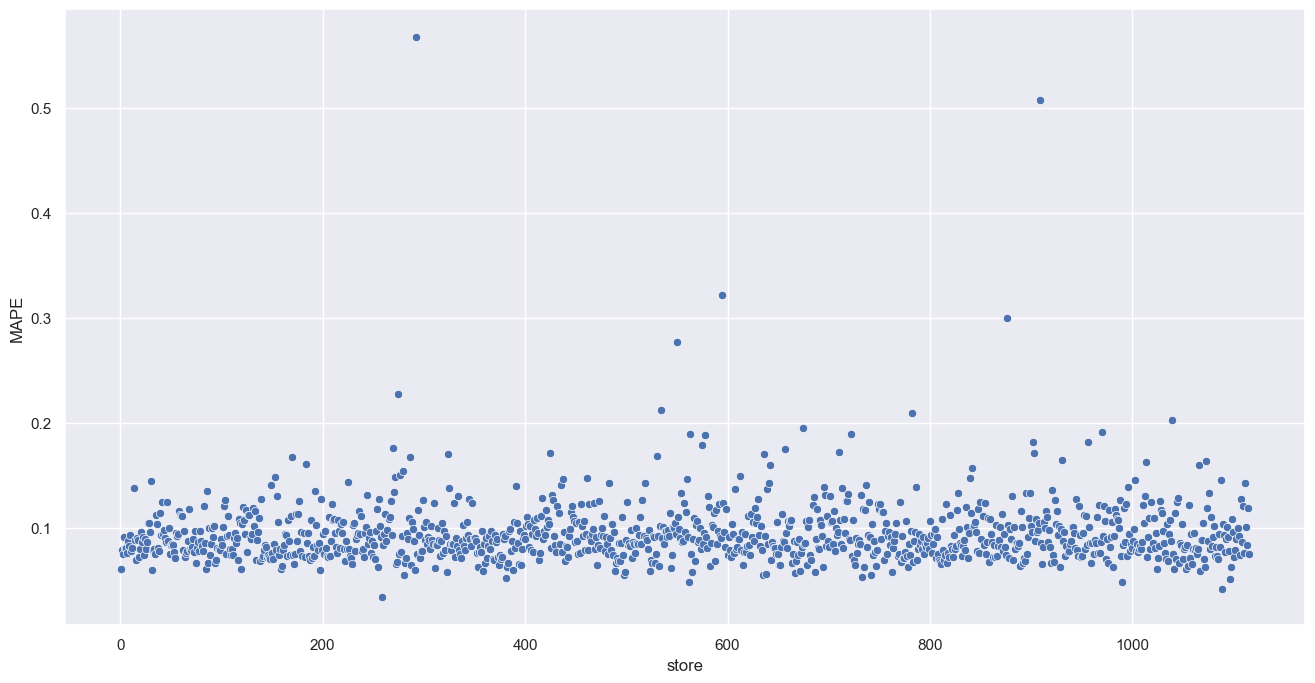

In [81]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [82]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"$283,273,664.00"
1,worst_scenario,"$282,542,954.28"
2,best_scenario,"$284,004,341.40"


## 9.3 Machine Learning Performance

In [83]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

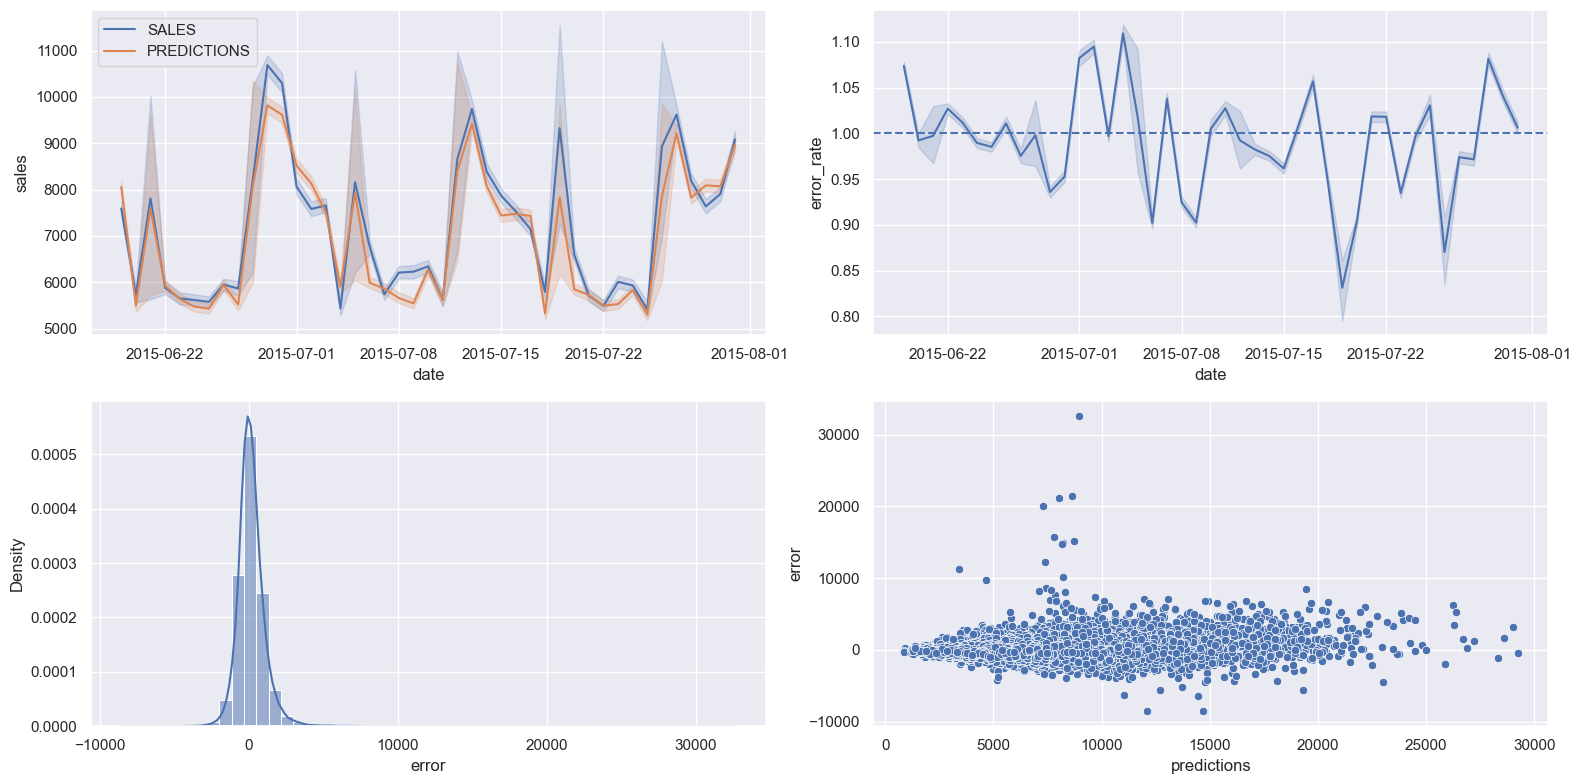

In [84]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'], stat='density', kde=True, bins=50)

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

plt.tight_layout()

# 10.0 Deploy Model to Production

In [92]:
# Save trained model
#pickle.dump(model_xgb_tuned, open('C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/model/model_rossmann.pkl', 'wb'))

# Compressing trained model file
#dump(model_xgb_tuned, 'C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/model/model_rossmann.pkl', compress=('lzma', 3))

# Checking file size
file_path = 'C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/model/model_rossmann.pkl'
print(f"File Size: {os.path.getsize(file_path) / (1024 * 1024):.2f} MB")

File Size: 29.25 MB


## 10.1 Rossmann Class

In [86]:
#import pickle
#import inflection
#import pandas as pd
#import numpy as np
#import math
#import datetime
#
#class Rossmann(object):
#    def __init__(self):
#        self.home_path = 'C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/'
#        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
#        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
#        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
#        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
#        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
#
#    def data_cleaning(self, df1):
#
#        ## 1.1 Rename Columns
#        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
#                    'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
#
#        snakecase = lambda x: inflection.underscore(x)
#
#        cols_new = list(map(snakecase, cols_old))
#
#        # rename
#        df1.columns = cols_new
#
#        ## 1.3 Data Types
#        df1['date'] = pd.to_datetime(df1['date'])
#
#        ## 1.5 Fillout NA
#        #competition_distance
#        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#
#        #competition_open_since_month
#        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#
#        #competition_open_since_year
#        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#
#        #promo2_since_week
#        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#
#        #promo2_since_year
#        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#
#        #promo_interval
#        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
#
#        df1['promo_interval'].fillna(0, inplace=True)
#
#        df1['month_map'] = df1['date'].dt.month.map(month_map)
#
#        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
#
#        ## 1.6 Change Data Types
#        # competition
#        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
#        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
#
#        # promo2
#        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
#        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
#
#        return df1
#    
#    def feature_engineering(self, df2):
#
#        # year
#        df2['year'] = df2['date'].dt.year
#
#        # month
#        df2['month'] = df2['date'].dt.month
#
#        # day
#        df2['day'] = df2['date'].dt.day
#
#        # week of year
#        df2['week_of_year'] = df2['date'].dt.isocalendar().week
#
#        # year week
#        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
#
#        # competition since
#        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)
#
#        # promo since
#        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
#        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)
#
#        # assortment
#        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
#
#        # state holiday
#        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
#        
#        # 3.0 Variable Filtering
#        ## 3.1 Rows Filtering
#        df2 = df2[df2['open'] != 0]
#
#        ## 3.2 Columns Selection
#        cols_drop = ['open', 'promo_interval', 'month_map']
#        df2 = df2.drop(cols_drop, axis=1)
#
#        return df2
#    
#    def data_preparation(self, df5):
#
#        ## 5.2 Rescaling
#        # competition distance
#        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
#        
#        # competition time month
#        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
#        
#        # promo time week
#        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
#        
#        # year
#        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
#        
#        ### 5.3.1 Encoding
#        # state holiday - One Hot Encoding
#        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)
#
#        # store type - Label Encoding
#        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
#
#        # assortment - Ordinal Encoding
#        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
#        df5['assortment'] = df5['assortment'].map(assortment_dict)
#
#        ### 5.3.3 Nature Transformation
#        # day of week
#        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi / 7)))
#        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi / 7)))
#
#        # month
#        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
#        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi / 12)))
#
#        # day
#        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
#        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi / 30)))
#
#        # week of year
#        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
#        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi / 52)))
#
#        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
#                         'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
#                         'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
#        
#        return df5[cols_selected]
#    
#    def get_prediction(self, model, original_data, test_data):
#        # prediction
#        pred = model.predict(test_data)
#
#        # join pred into the original data
#        original_data['prediction'] = np.expm1(pred)
#
#        return original_data.to_json(orient='records', data_format='iso')

## 10.2 API Handler

In [87]:
#import pickle
#import pandas as pd
#from flask             import Flask, request, Response
#from rossmann.Rossmann import Rossmann
#
## loading model
#model = pickle.load(open('C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/model/model_rossmann.pkl', 'rb'))
#
## initialize API
#app = Flask(__name__)
#
#@app.route('/rossmann/predict', methods=['POST'])
#def rossmann_predict():
#    test_json = request.get_json()
#
#    if test_json: # there is data
#        if isinstance(test_json, dict): # unique example
#            test_raw = pd.DataFrame(test_json, index=[0])
#
#        else: # multiple example
#            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
#
#        # Instantiate Rossmann Class
#        pipeline = Rossmann()
#
#        # data cleaning
#        df1 = pipeline.data_cleaning(test_raw)
#        
#        # feature engineering
#        df2 = pipeline.feature_engineering(df1)
#
#        # data preparation
#        df3 = pipeline.data_preparation(df2)
#
#        # prediction
#        df_response = pipeline.get_prediction(model, test_raw, df3)
#
#        return df_response
#
#    else:
#        return Response('{}', status=200, mimetype='application/json')
#
#if __name__ == '__main__':
#    app.run('0.0.0.0')

## 10.3 API Tester

In [93]:
# loading test dataset
df10 = pd.read_csv('C:/Users/alefa/Dropbox/DESKTOP/DESK_DS/COMUNIDADE_DS_06.2024/repos/pa_rossmann/dataset/test.csv')

In [94]:
# merge test dataset + store dataset
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([45, 52])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [95]:
# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [96]:
# API Call
url = 'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data, headers=header)
print(f'Status Code {r.status_code}')

Status Code 200


In [97]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [98]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range (len(d2)):
    print("Store Number {} will sell ${:,.2f} in the next 6 weeks".format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 45 will sell $170,954.18 in the next 6 weeks
Store Number 52 will sell $357,592.56 in the next 6 weeks
